In [1]:
import pandas as pd

classifications = pd.read_csv('./fashion-labels.csv')

classifications_names = {
    0: '上身衣服',
    1: '鞋',
    2: '包',
    3: '下身衣服',
    4: '手表'
}

In [2]:
import torch
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
class FolderDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        img_idx = int(img_loc.split('/')[-1].split('.')[0])
        img_idx = classifications.loc[classifications['id'] == img_idx, 'target'].iloc[0]

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, img_idx

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

transforms = T.Compose([T.Resize((64, 64)), T.ToTensor()])
print("------------ Creating Dataset ------------")
full_dataset = FolderDataset('./image_similarity/dataset/', transforms)

train_size = int(0.75 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

print("------------ Dataset Created ------------")
print("------------ Creating DataLoader ------------")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32
)

full_loader = torch.utils.data.DataLoader(
    full_dataset, batch_size=32
)

for (x, y) in train_loader:
    print(x.shape)
    print(y.shape)
    break

------------ Creating Dataset ------------
------------ Dataset Created ------------
------------ Creating DataLoader ------------
torch.Size([32, 3, 64, 64])
torch.Size([32])


In [5]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # Same convolutions -> output -> same as input dimension
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # last conv out was 8 so this conv input is 8.

        self.fc1 = nn.Linear(16*16*16, num_classes)
        # in fc1 -> 16 bcoz that is outchannel in conv2 and 7*7 because -> 2 poolings will make it (28/2)/2 => 7

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

        # return x

model = CNN()
print(model)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=5, bias=True)
)
torch.Size([32, 5])


In [6]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# number of epochs to train the model
n_epochs = 20

model.to(device)

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for (x, y) in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        x = x.to(device)
        y = y.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        output = model(x)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(output, y)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*x.size(0)

    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 7.090906
Epoch: 2 	Training Loss: 2.275481
Epoch: 3 	Training Loss: 1.781287
Epoch: 4 	Training Loss: 1.447114
Epoch: 5 	Training Loss: 1.187183
Epoch: 6 	Training Loss: 1.034171
Epoch: 7 	Training Loss: 0.864651
Epoch: 8 	Training Loss: 0.717582
Epoch: 9 	Training Loss: 0.662205
Epoch: 10 	Training Loss: 0.531031
Epoch: 11 	Training Loss: 0.467053
Epoch: 12 	Training Loss: 0.376934
Epoch: 13 	Training Loss: 0.364884
Epoch: 14 	Training Loss: 0.385344
Epoch: 15 	Training Loss: 0.278056
Epoch: 16 	Training Loss: 0.277556
Epoch: 17 	Training Loss: 0.187719
Epoch: 18 	Training Loss: 0.211454
Epoch: 19 	Training Loss: 0.246444
Epoch: 20 	Training Loss: 0.162586


(32, 5)
(32, 64, 64, 3)


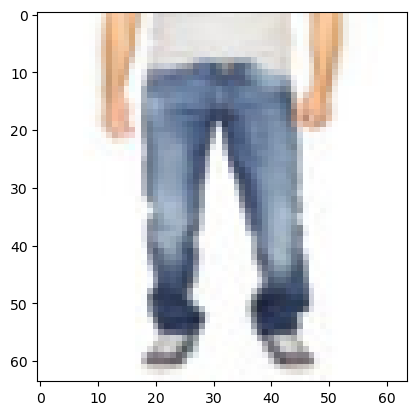

下身衣服


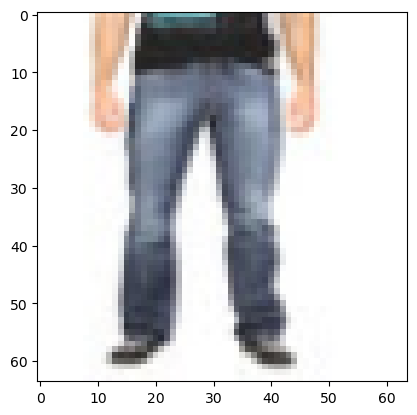

下身衣服


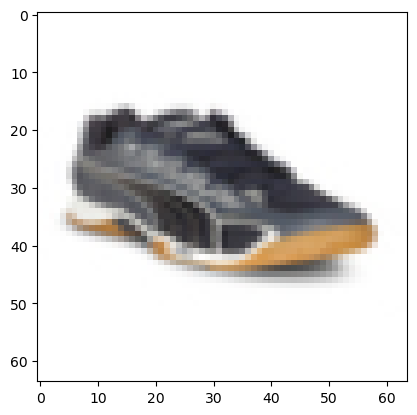

鞋


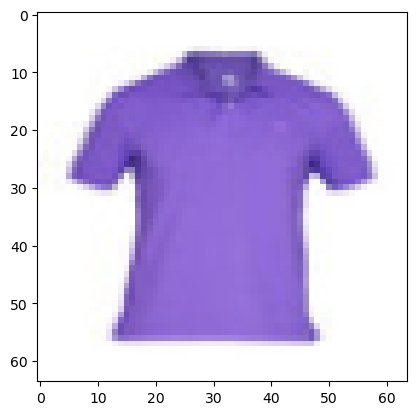

上身衣服


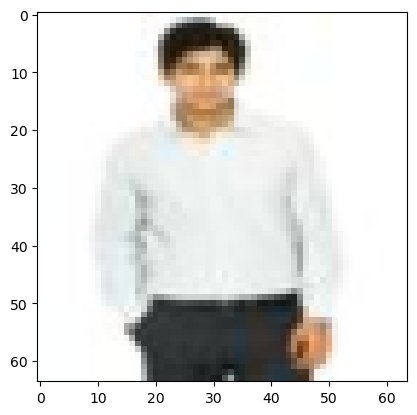

上身衣服


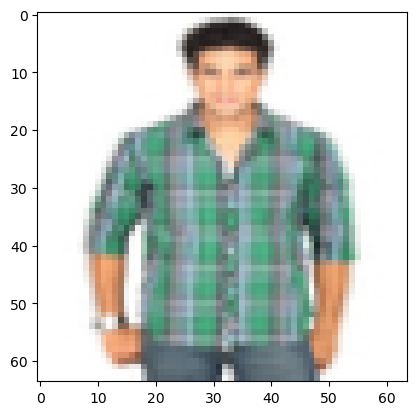

上身衣服


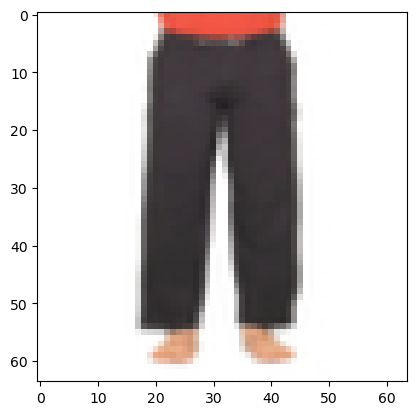

下身衣服


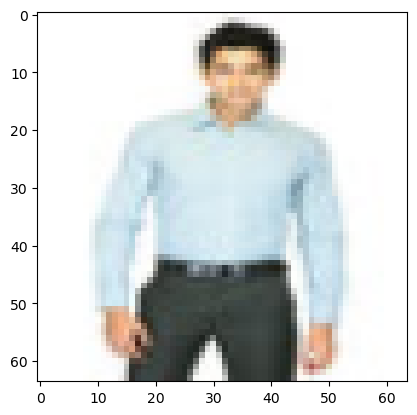

上身衣服


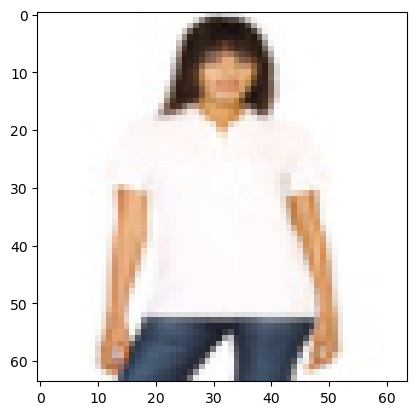

上身衣服


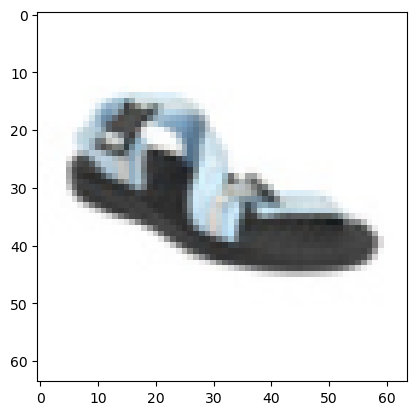

鞋


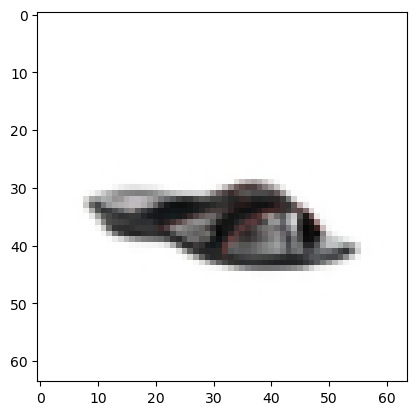

鞋


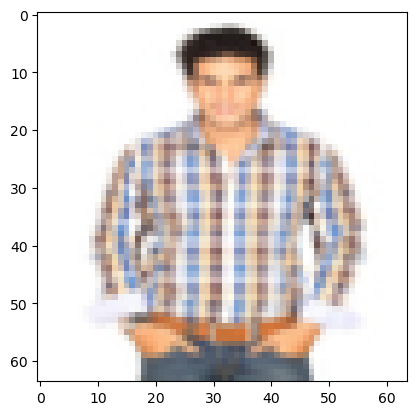

上身衣服


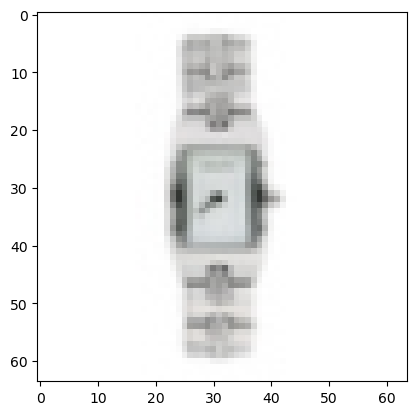

手表


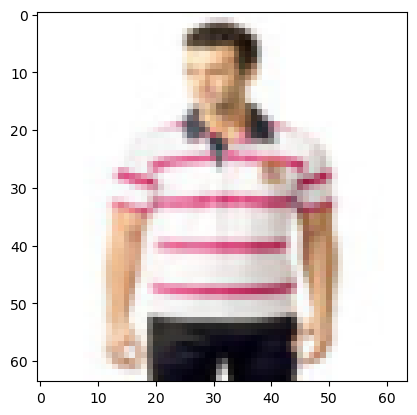

上身衣服


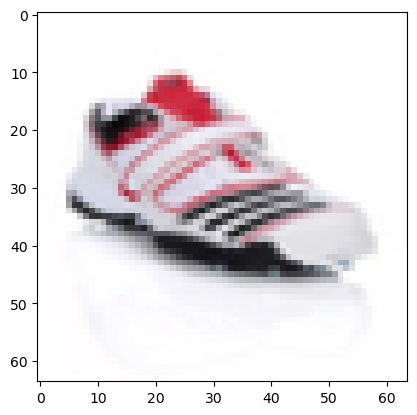

鞋


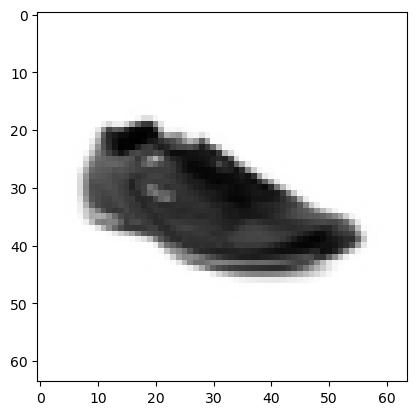

鞋


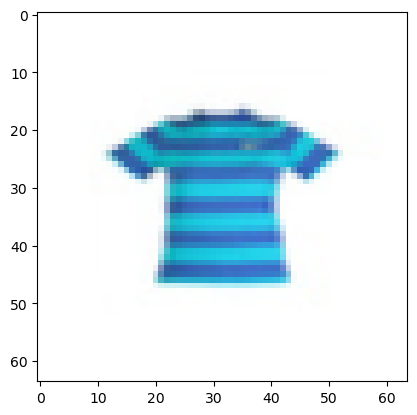

上身衣服


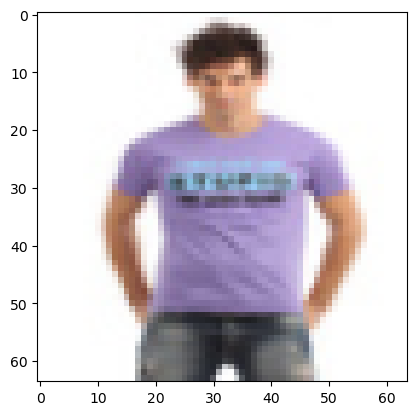

上身衣服


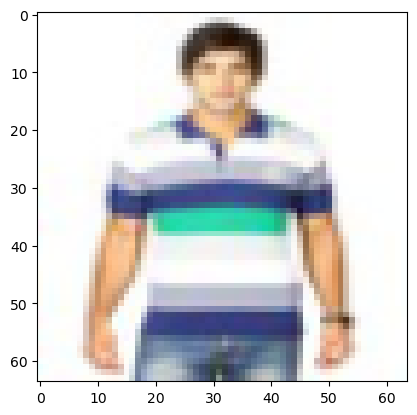

上身衣服


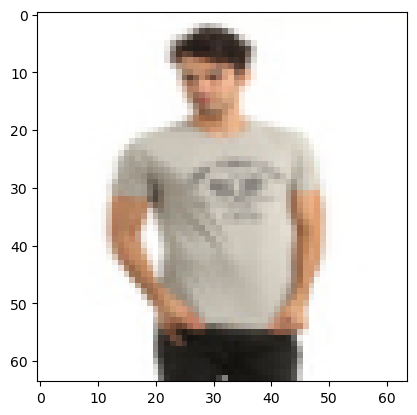

上身衣服


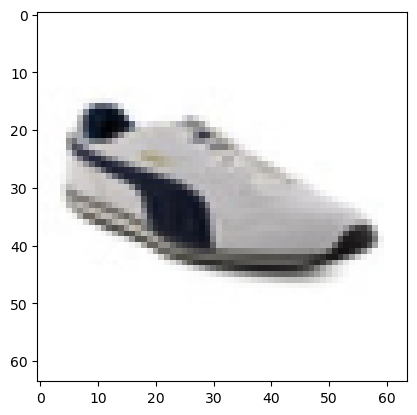

鞋


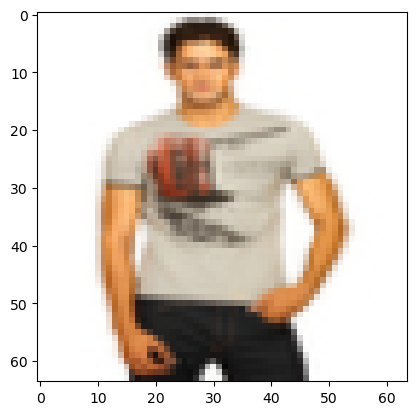

上身衣服


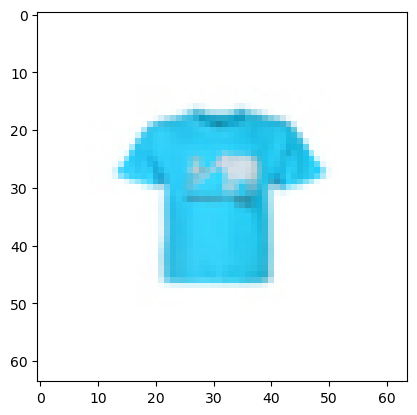

上身衣服


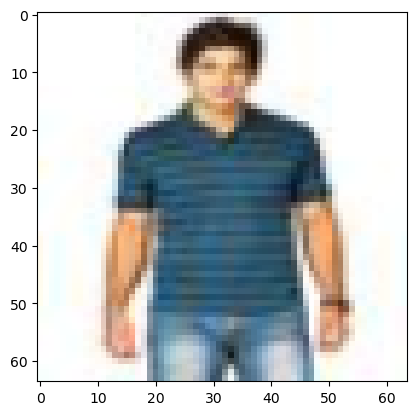

上身衣服


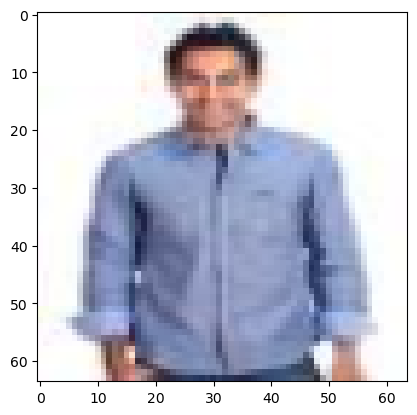

上身衣服


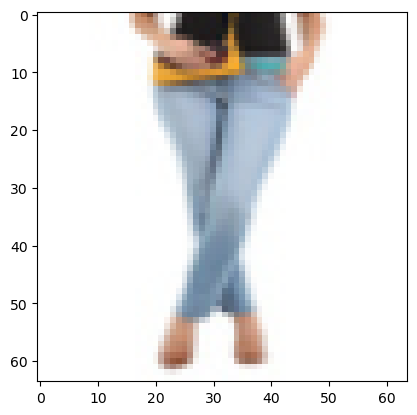

下身衣服


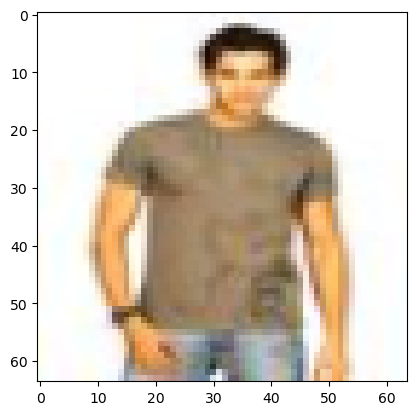

上身衣服


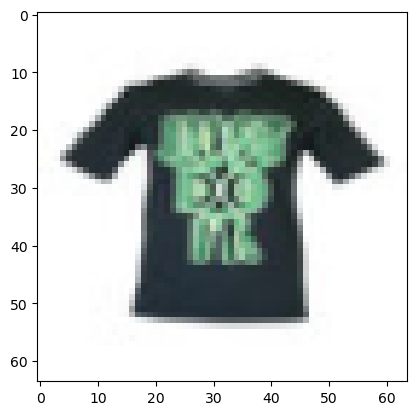

上身衣服


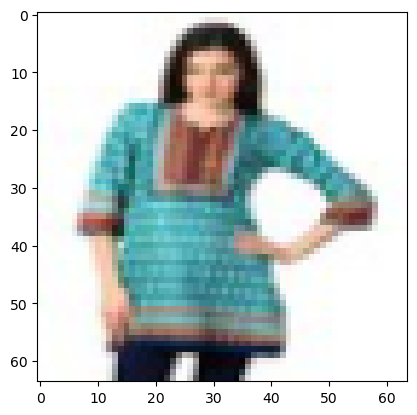

上身衣服


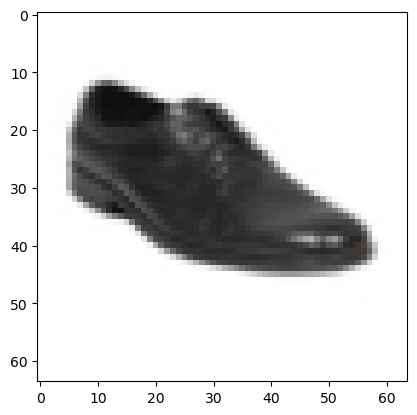

鞋


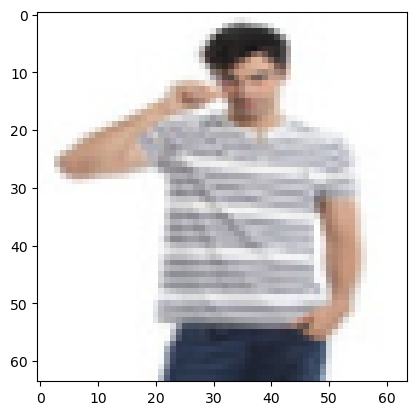

上身衣服


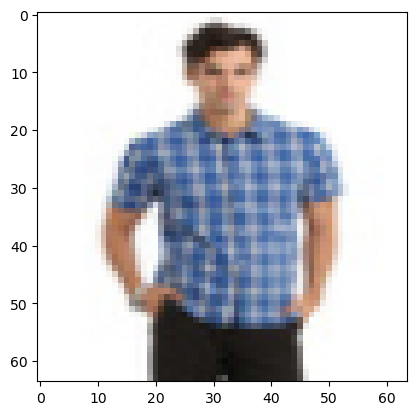

上身衣服


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn.functional as F
# obtain one batch of test images
dataiter = iter(val_loader)
images, labels = next(dataiter)

model.to('cpu')
# get sample outputs
output = model(images)
output = output.detach().numpy()
print(output.shape)
# prep images for display

images = images.numpy()
images = np.moveaxis(images, 1, -1)
print(images.shape)

# plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
# for imgs, row in zip([images, output], axes):
#     for img, ax in zip(imgs, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
# plt.show()
for img, label in zip(images, output):
    plt.imshow(img)
    plt.show()
    print(classifications_names[np.argmax(label)])
